**Import Libraries**

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns


**Load & Preprocess Data**

In [2]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/gh_food_nutritional_values.csv')
df['Food'] = df['Food'].str.strip().str.lower()

In [3]:
# Define and clean nutritional columns
nutritional_columns = [
    'Protein(g)', 'Fat(g)', 'Carbs(g)', 'Calories(100g)',
    'Water(g)', 'SFA(100g)', 'MUFA(100g)', 'PUFA(100g)'
]
df[nutritional_columns] = df[nutritional_columns].fillna(df[nutritional_columns].mean())

In [4]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[nutritional_columns])

In [14]:
# Dimensionality reduction
pca = PCA(n_components=0.95, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

**Model Implementation**

In [16]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def knn_indices(query_index, data, k=5):
    query_vec = data[query_index]
    similarities = []
    for i, vec in enumerate(data):
        if i != query_index:
            sim = cosine_similarity(query_vec, vec)
            similarities.append((i, sim))
    similarities.sort(key=lambda x: x[1], reverse=True)
    return [idx for idx, _ in similarities[:k]]


In [17]:
def recommend_food(food_name, df, data, k=5):
    df['Food'] = df['Food'].str.lower()
    food_name = food_name.lower()

    if food_name not in df['Food'].values:
        print(f"Food '{food_name}' not found.")
        return df['Food'].sample(3).tolist()

    index = df[df['Food'] == food_name].index[0]
    neighbors = knn_indices(index, data, k=k+1)
    return [df.iloc[i]['Food'] for i in neighbors if i != index][:k]


Train Model

In [22]:
# Split for evaluation
X_train, X_test, y_train_idx, y_test_idx = train_test_split(
    X_pca, np.arange(len(X_pca)), test_size=0.3, random_state=42
)

In [25]:
def visualize_knn_clusters(data, df, food_name, k=5, n_clusters=6):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)

    query_index = df[df['Food'] == food_name.lower()].index[0]
    neighbor_indices = knn_indices(query_index, data, k=k)

    plt.figure(figsize=(14, 10))
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=cluster_labels, palette='tab10', s=100, alpha=0.8)

    plt.scatter(data[query_index, 0], data[query_index, 1], color='black', s=120, marker='*', label='Query Food')

    for i in neighbor_indices:
        plt.scatter(data[i, 0], data[i, 1], color='red', edgecolor='black', s=120)
        plt.text(data[i, 0] + 0.03, data[i, 1] + 0.03, df['Food'].iloc[i], fontsize=9)

    plt.title(f"KNN Neighborhood and Clusters for '{food_name}'")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


**Viewing Food Clusters**

Top recommendations for 'rice': ['eto', 'akpler', 'ga kenkey', 'cassava & plantain fufu', 'banana']


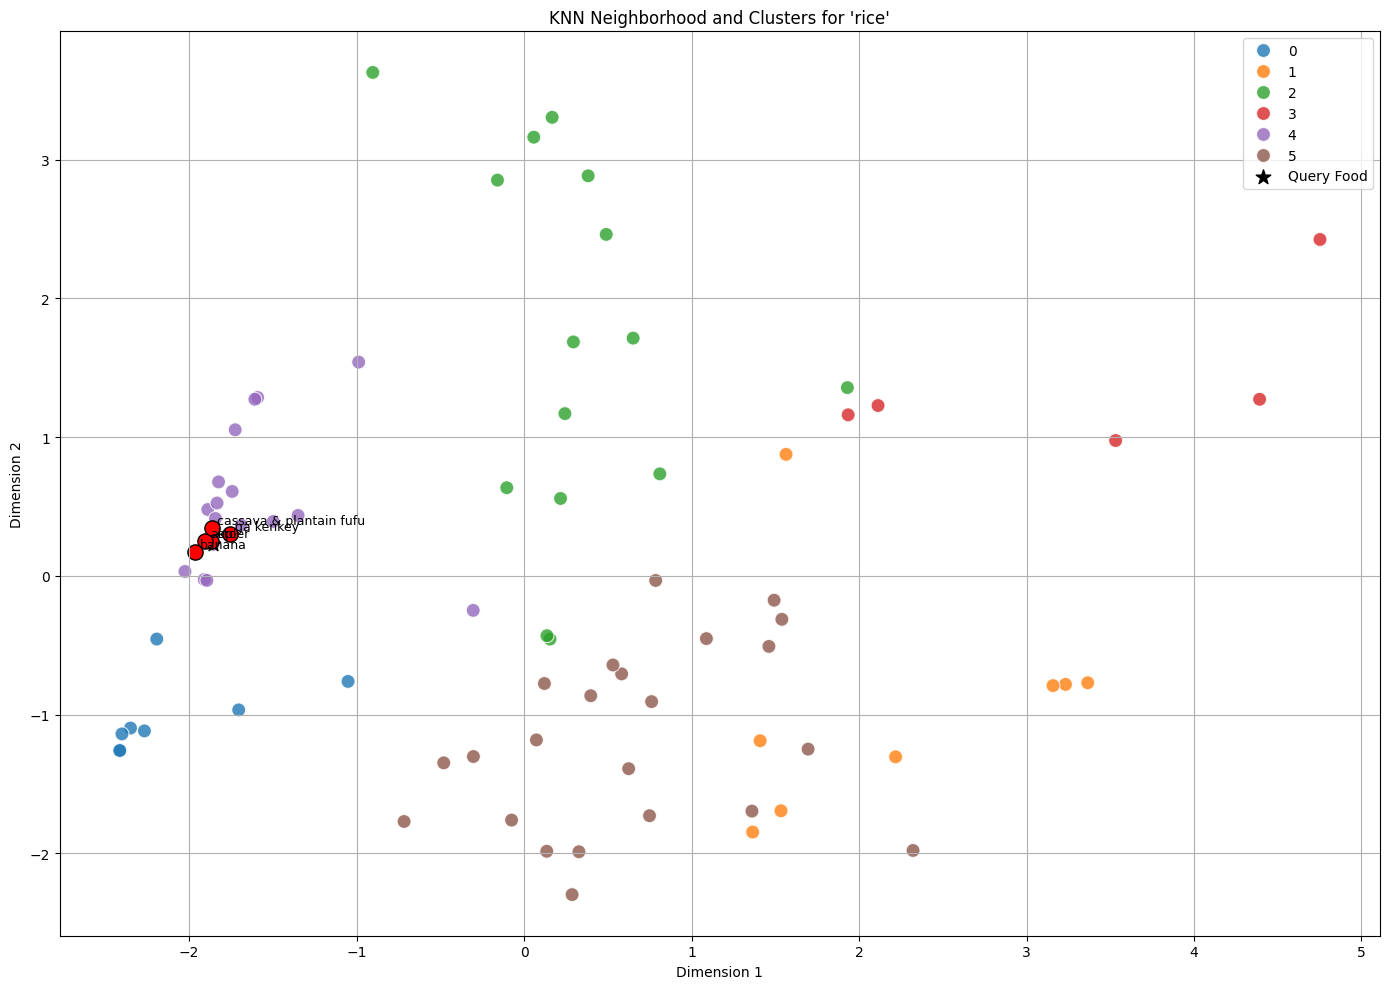

In [26]:
food_query = "rice"
results = recommend_food(food_query, df.copy(), X_pca, k=5)
print(f"Top recommendations for '{food_query}': {results}")

visualize_knn_clusters(X_pca, df.copy(), food_query, k=5, n_clusters=6)
